Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


hcad length (702356, 285)
y_data length (702356, 10)


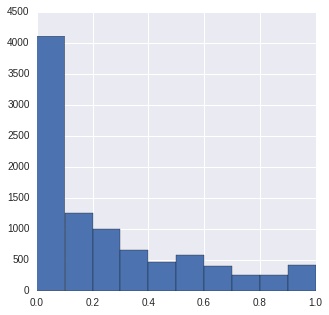

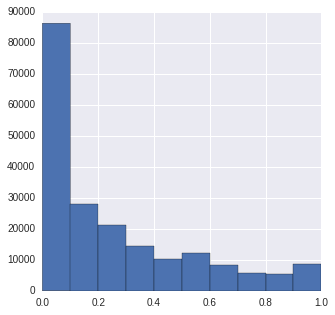

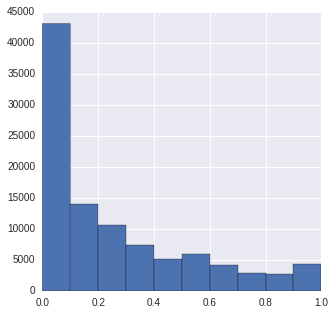

(array([[[[  5.20890000e+11],
          [  5.20890000e+11],
          [  5.20890000e+11],
          ..., 
          [ -9.43102371e-01],
          [ -9.38420319e-01],
          [ -9.23529575e-01]]],
 
 
        [[[  8.04100000e+11],
          [  8.04100000e+11],
          [  8.04100000e+11],
          ..., 
          [ -1.00000000e+00],
          [ -9.98788669e-01],
          [ -9.87121062e-01]]],
 
 
        [[[  1.12749000e+12],
          [  1.12749000e+12],
          [  1.12749000e+12],
          ..., 
          [ -9.97697506e-01],
          [ -9.83940032e-01],
          [ -9.87278942e-01]]],
 
 
        ..., 
        [[[  1.02053000e+12],
          [  1.02053000e+12],
          [  1.02053000e+12],
          ..., 
          [ -9.98133666e-01],
          [ -9.96485029e-01],
          [ -9.87410417e-01]]],
 
 
        [[[  7.51120050e+11],
          [  7.51120050e+11],
          [  7.51120050e+11],
          ..., 
          [ -9.73680306e-01],
          [ -9.35021625e-01],
          [ 

In [38]:
%matplotlib inline
%pylab inline
import pylab
pylab.rcParams['figure.figsize'] = (5.0, 5.0)
from tsne import bh_sne # thi is the correct tsne to use.  It's the one discussed btnw
from bhtsne import bh_tsne
import sklearn.manifold
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
from sklearn.preprocessing import normalize
from collections import defaultdict
def memo(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

def zero_to_one(array):
    # array = array - np.min(array)
    # array = 2*(array/np.max(array))-1
    # return np.nan_to_num(array)
    array = array.replace([np.inf, -np.inf], 1)
    array = array.fillna(0)
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range = (-1,1))
    return scaler.fit_transform(array)


# @memo
def load_dataset(path, scale=True, include_hcad = True):
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    if scale:
        for label in df._get_numeric_data().columns:
            if label != 'hcad':
                df[label] = df[label].astype(float)
                df[label] = zero_to_one(df[label])
                df[label][df[label] > 1] = 1.0
    if include_hcad:
        df['hcad'] = df['hcad'].astype(int)
    df = df.replace([np.inf, -np.inf], 1)
    
    return df.sort(['hcad']).fillna(0)
    
def old_tsne(df_data, dest_folder, n = None, file_tag= "", embedded_dimensions=2, perplexity = 50):
    result_2d = {}
    result_2d['hcad'] = df_data['hcad'][:n]
    df_data = df_data.drop('hcad', 1) # don't embed the hcad number!
    df_data = np.array(df_data)[:n]
    embedding = bh_sne(np.array(df_data)[:n], perplexity=perplexity)
#     embedding = bh_sne(np.array(df_data))
    result_2d['x'] = zero_to_one(embedding[:, 0])
    result_2d['y'] = zero_to_one(embedding[:, 1])
    result_2d = pandas.DataFrame.from_dict(result_2d)
    #name = file_tag+"_"+"_".join(df_data.columns)[:40] + "_n:"+str(len(result))
    #result.to_pickle(dest_folder+name)
    return embedding


def tsne(df_data, dest_folder, n = None, file_tag= "", embedded_dimensions=2, perplexity = 50):
    result_2d = {}
    result_2d['hcad'] = df_data['hcad'][:n]
    df_data = df_data.drop('hcad', 1) # don't embed the hcad number!
    df_data = np.array(df_data)[:n]
    embedding = np.array(list(bh_tsne(np.array(df_data)[:n], perplexity=perplexity)))
#     embedding = bh_sne(np.array(df_data))
    print(embedding)

    result_2d['x'] = zero_to_one(embedding[:, 0])
    result_2d['y'] = zero_to_one(embedding[:, 1])
    result_2d = pandas.DataFrame.from_dict(result_2d)
    #name = file_tag+"_"+"_".join(df_data.columns)[:40] + "_n:"+str(len(result))
    #result.to_pickle(dest_folder+name)
    return embedding

def hist_2d(vis_x,vis_y):
    hh, locx, locy = scipy.histogram2d(vis_x, vis_y, bins=[200,200])
    fig = plt.figure(frameon=False)
    fig.set_size_inches(30,30)
    plt.imshow(np.flipud(hh.T),cmap='jet', interpolation='none', shape = (1,1))
    plt.colorbar()
    
def get_where_img0_is_1(pddf):
    img0_metadata = (META.loc[META['img0'] == 1])
    return pddf.loc[pddf['hcad'].isin(list(img0_metadata['hcad']))]

def pairwise_plot(pddf, sqrt = False):
    if sqrt:
        pddf = np.sqrt(pddf)
    axes = pandas.tools.plotting.scatter_matrix(pddf, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    
    
    
def old_fast_show_ratio_plot(xy_points, y_data, log = False, normalize_buckets=True):
    if log:
        y_data = np.log(y_data)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(3,3)
    plt.hist(y_data)
    plt.show()

    buckets = defaultdict(list)
    resolution = 200
    x = np.array(xy_points['x'])
    y = np.array(xy_points['y'])
    H, xedges, yedges = numpy.histogram2d(x,y, bins=resolution, weights = y_data)
    H_nums, dummy2, dummy1 = numpy.histogram2d(x,y, bins=resolution)
    plt.show()
    fig = plt.figure(frameon=False)
    fig.set_size_inches(12,12)
    if normalize_buckets:
        H=H/H_nums
    H[H_nums == 0.0] = numpy.nan
#     if log:
#         H = np.log(H)
    

    plt.imshow(H, 
               interpolation='nearest', cmap=cm.gist_rainbow)
    plt.colorbar()
    plt.show()
    return np.nan_to_num(H)
    
    
    
    
    
    
    
    
    
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val, max_bucket_size):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)
    self.max_bucket_size = max_bucket_size
    print("buckets", self.max_bucket_size)

  def get_rgb(self, val):
    ret = list( plt.get_cmap('jet')(val[0]))
    
    ret[-1] = 1#(val[1] / self.max_bucket_size)**.5
    return tuple(ret)
#     return(1,0,0,1)
    

def fast_show_ratio_plot(xy_points, y_data, log = False, normalize_buckets=True):
    
    if log:
        y_data = np.log(y_data)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(3,3)
    plt.hist(y_data)
    plt.show()

    buckets = defaultdict(list)
    resolution = 400
    x = np.array(xy_points['x'])
    y = np.array(xy_points['y'])
    H, xedges, yedges = numpy.histogram2d(x,y, bins=resolution, weights = y_data)
    H_nums, dummy2, dummy1 = numpy.histogram2d(x,y, bins=resolution)
    plt.show()
    fig = plt.figure(frameon=False)
    fig.set_size_inches(12,12)
    if normalize_buckets:
        H=H/H_nums
#     H = zero_to_one(H)
    H[H_nums == 0.0] = 0
    print("H:",np.max(H))
    
    colormap = MplColorHelper('viridis', np.min(H), np.max(H), np.max(H_nums))

#     if log:
#         H = np.log(H)
    image = np.zeros([resolution,resolution, 4])
    for i in range(resolution):
        for j in range(resolution):
            image[i,j] = colormap.get_rgb((H[i,j], H_nums[i,j]))
    print("image colors",image[image[:,:,3] > 0.1])

#     print(zip(H, H_nums))
#     image  = np.vectorize(colormap.get_rgb)(zip(H, H_nums))
    plt.imshow(image,  interpolation='nearest')
#     plt.imshow(H_nums,  interpolation='nearest')
    plt.gca().set_axis_bgcolor('white')
    plt.colorbar()
    plt.show()
    return np.nan_to_num(H)


#===============================================================================

def colored_scatter(xy_points, y_data):
        fig = plt.figure(frameon=False)
        fig.set_size_inches(20,20)
        plt.scatter(xy_points['x'], xy_points['y'], c=y_data,  marker='x', facecolor='b', cmap='jet')
        plt.colorbar()
        plt.show()

def shuffle_in_unison(a, b):
    rng_state = numpy.random.get_state()
    numpy.random.shuffle(a)
    numpy.random.set_state(rng_state)
    numpy.random.shuffle(b)
        
def load_mega_hcad():
    # hcad = load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df.hd")
#     hcad_data = img0_hcad_data
#     WIND = img0_wind_data
#     Y_DATA = img0_y_data

    mega_hcad = {}

    for column in hcad_data[0]:
        for index, dataset in enumerate(hcad_data):
            mega_hcad[column+"_hcad_"+str(index)] = dataset[column]
    for column in WIND:
        if not 'hist' in column:
            mega_hcad[column+"_wind"] = WIND[column]
    mega_hcad = pandas.DataFrame.from_dict(mega_hcad).as_matrix()
    #print( Y_DATA)
    y_data_np = Y_DATA.as_matrix()
    shuffle_in_unison(mega_hcad, y_data_np)
    
    y_column = 6
    mega_hcad_nonzero = mega_hcad[y_data_np[:,y_column]!=0]
    y_data_np_nonzero = y_data_np[y_data_np[:, y_column]!=0]
    mega_hcad_zero = mega_hcad[y_data_np[:,y_column]==0][:250000]
    y_data_np_zero = y_data_np[y_data_np[:,y_column]==0][:250000]
    
    mega_hcad = np.concatenate((mega_hcad_nonzero, mega_hcad_zero), axis=0)
    y_data_np = np.concatenate((y_data_np_nonzero, y_data_np_zero), axis=0)
    #mega_hcad.append(mega_hcad_zero)
    #y_data
    shuffle_in_unison(mega_hcad, y_data_np)

    
    print("hcad length", (mega_hcad.shape))
    print("y_data length", (y_data_np.shape))
    #print (mega_hcad)


    X_train = np.expand_dims(np.expand_dims(mega_hcad[:4*len(y_data_np)/300], axis=1), axis=3)
    y_train = y_data_np[:4*len(y_data_np)/300, y_column] # limit training data amount, as opposed to 600000
#     print("y train",y_train.shape)
    X_val = np.expand_dims(np.expand_dims(mega_hcad[4*len(y_data_np)/7: 6*len(y_data_np)/7], axis=1), axis=3)
    y_val = y_data_np[4*len(y_data_np)/7: 6*len(y_data_np)/7, y_column]
    X_test = np.expand_dims(np.expand_dims(mega_hcad[6*len(y_data_np)/7:], axis=1), axis=3)
    y_test = y_data_np[6*len(y_data_np)/7:, y_column]
    plt.hist(y_train)
    plt.show()
    plt.hist(y_val)
    plt.show()
    plt.hist(y_test)
    plt.show()
    return X_train, y_train, X_val, y_val, X_test, y_test
load_mega_hcad()
# tsne_embed = pandas.read_pickle("/home/isaac/Desktop/devika/gitignored/img1_hcad/_mean_accrued_depr_pct_std_accrued_depr_p_n:104878")
# hist_2d(np.array(tsne_embed['x']),np.array(tsne_embed['y']))

### load all the data at 200m

In [35]:
hcad_data = [
    load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_100.hd", include_hcad= False),
     load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd", include_hcad= False),
     load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_400.hd", include_hcad= False),
    load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd", include_hcad= False)]

hcad = load_dataset("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd")
# hcad = hcad[['hcad', 'mean_accrued_depr_pct', 'mean_bld_val', 'mean_land_val','mean_quality','mean_rcnld', 'mean_tot_mkt_val','mean_year_built','mean_year_remodeled']]
META = load_dataset("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
WIND = load_dataset("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd")
TERRAIN = load_dataset("/home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd")

Y_DATA = load_dataset("/home/isaac/Dropbox/data_for_brian/y_df.hd", scale = False)
img0_y_data = get_where_img0_is_1(Y_DATA)


# @memo
img0_terrain_data = get_where_img0_is_1(TERRAIN)
img0_wind_data = get_where_img0_is_1(WIND)
img0_hcad_data = get_where_img0_is_1(hcad)
img0_metadata = (META.loc[META['img0'] == 1])
# print get_where_img0_is_1(WIND)
def plot_on_map(pddf, meta = META):
    for col in pddf.columns:
        print("\n\n\n",col)
        xy = pandas.DataFrame.from_dict({'x': -meta['pointx'],'y': meta['pointy']})
        print("linear plot")
        fast_show_ratio_plot(xy,np.array(pddf[col]))
        print("log plot")
        fast_show_ratio_plot(xy,np.array(pddf[col]), log = True)
        colored_scatter(xy,np.array(pddf[col]))

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_100.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_400.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_1000.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/terrain_features/dsmgrid/terrain_200.hd in read-only mode


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode


In [4]:
WIND = load_dataset("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd", scale = False)
for thing in WIND:
        print(thing)

Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad200_hist16x16.mat.hd in read-only mode
hcad
lat
lon
intp_spd0
intp_dir0
intp_spd1
intp_dir1
intp_spd2
intp_dir2
intp_spd3
intp_dir3
intp_spd4
intp_dir4
intp_spd5
intp_dir5
intp_spd6
intp_dir6
intp_spd7
intp_dir7
intp_spd8
intp_dir8
intp_spd9
intp_dir9
intp_spd10
intp_dir10
hist0
hist1
hist2
hist3
hist4
hist5
hist6
hist7
hist8
hist9
hist10
hist11
hist12
hist13
hist14
hist15
hist16
hist17
hist18
hist19
hist20
hist21
hist22
hist23
hist24
hist25
hist26
hist27
hist28
hist29
hist30
hist31
hist32
hist33
hist34
hist35
hist36
hist37
hist38
hist39
hist40
hist41
hist42
hist43
hist44
hist45
hist46
hist47
hist48
hist49
hist50
hist51
hist52
hist53
hist54
hist55
hist56
hist57
hist58
hist59
hist60
hist61
hist62
hist63
hist64
hist65
hist66
hist67
hist68
hist69
hist70
hist71
hist72
hist73
hist74
hist75
hist76
hist77
hist78
hist79
hist80
hist81
hist82
hist83
hist84
hist85
hist86
hist87
hist88
hist89
hist90
hist91
hist9

### make an embedding

In [ ]:
embedding_2d = tsne(img0_hcad_data ,"/home/isaac/Desktop/devika/gitignored/6_dimensions_hcad_img0/", 
                 file_tag ="hcad_img0", n=104876, embedded_dimensions=2)



In [ ]:
old_fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': embedding_2d[:,0],
                                             'y': embedding_2d[:,1]}), np.array(img0_y_data['y200_mean'])[:104876])

In [ ]:
old_embedding_2d = old_tsne(img0_hcad_data ,"/home/isaac/Desktop/devika/gitignored/6_dimensions_hcad_img0/", 
                 file_tag ="hcad_img0", n=1000, embedded_dimensions=2)

old_fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': old_embedding_2d[:,0],
                                             'y': embedding_2d[:,1]}), np.array(img0_y_data['y200_mean'])[:1000])

### kmeans cluster the data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
kmeans = KMeans(init='k-means++', n_clusters=30)
kmeans.fit(embedding_2d)
print kmeans.labels_

# np.random.shuffle(kmeans.labels_)
colored_scatter(pandas.DataFrame.from_dict({'x': - img0_metadata ['pointx'][:len(kmeans.labels_)],
                                            'y': img0_metadata['pointy'][:len(kmeans.labels_)]}), kmeans.labels_)
fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': - img0_metadata ['pointx'][:len(kmeans.labels_)],
                                                 'y': img0_metadata['pointy'][:len(kmeans.labels_)]}),kmeans.labels_)

for label in range(max(kmeans.labels_)+1):
    print "class", label, "damage:",np.mean(np.array(img0_y_data['y200_mean'])[numpy.where(kmeans.labels_==label)])

In [ ]:
print pandas.read_pickle("/home/isaac/Desktop/devika/gitignored/testing_refactored_code/_mean_accrued_depr_pct_std_accrued_depr_p_n:100")

In [ ]:
# print np.array(tsne_embed['x'])[0]
# show_ratio_plot(tsne_embed, hcad['mean_bld_val'])
# print get_meta()
# print Y_DATA

plot_on_map(img0_hcad_data, meta = img0_metadata)

 ### CNN

Loading data...
hcad length (702356, 285)
y_data length (702356, 10)


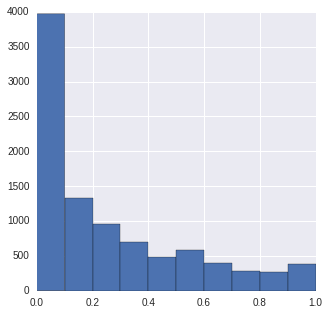

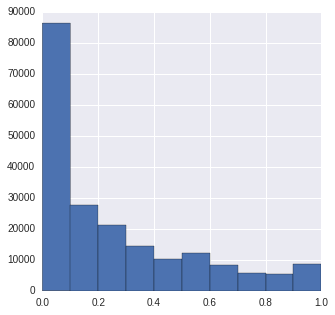

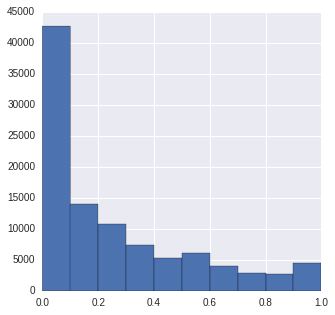

In [39]:

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_mega_hcad()



[ 0.          0.          1.         ...,  0.66666667  0.09090909  0.        ]
(9364,)
train max 1.0
x train shape (9364, 1, 285, 1)
Building model and compiling functions...
Starting training...
Epoch 1 of 500 took 0.321s
  training loss:		2.232792
  validation loss:		0.967135
  validation accuracy:		96.71 %


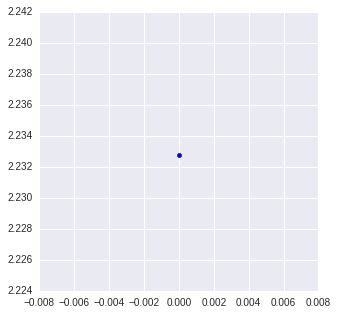

Epoch 2 of 500 took 0.326s
  training loss:		2.233652
  validation loss:		0.967115
  validation accuracy:		96.71 %


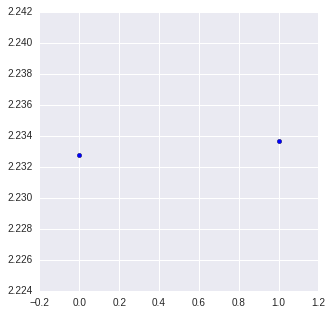

Epoch 3 of 500 took 0.323s
  training loss:		2.232613
  validation loss:		0.967180
  validation accuracy:		96.72 %


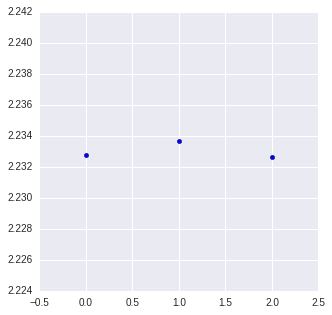

Epoch 4 of 500 took 0.307s
  training loss:		2.232570
  validation loss:		0.967145
  validation accuracy:		96.71 %


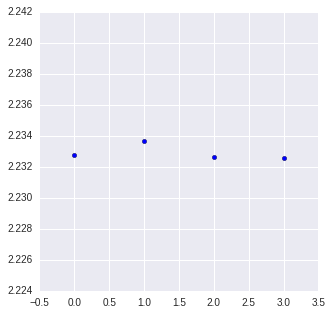

Epoch 5 of 500 took 0.322s
  training loss:		2.232748
  validation loss:		0.967150
  validation accuracy:		96.72 %


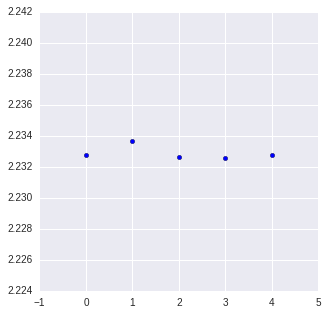

Epoch 6 of 500 took 0.311s
  training loss:		2.232703
  validation loss:		0.967125
  validation accuracy:		96.71 %


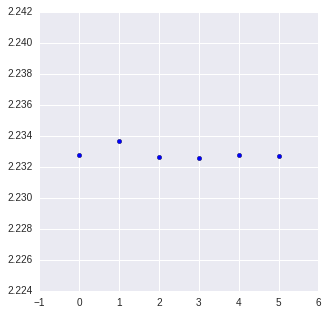

Epoch 7 of 500 took 0.309s
  training loss:		2.233546
  validation loss:		0.967115
  validation accuracy:		96.71 %


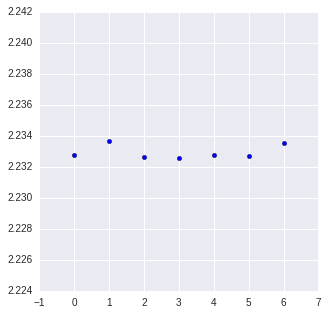

Epoch 8 of 500 took 0.279s
  training loss:		2.232723
  validation loss:		0.967155
  validation accuracy:		96.72 %


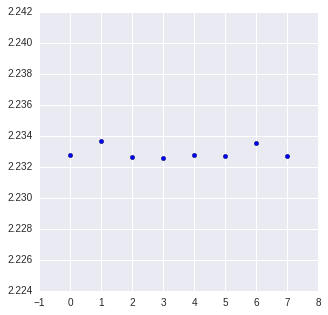

Epoch 9 of 500 took 0.262s
  training loss:		2.233455
  validation loss:		0.967150
  validation accuracy:		96.72 %


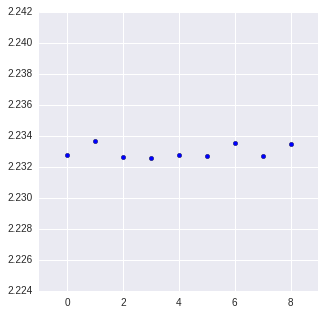

Epoch 10 of 500 took 0.273s
  training loss:		2.232854
  validation loss:		0.967140
  validation accuracy:		96.71 %


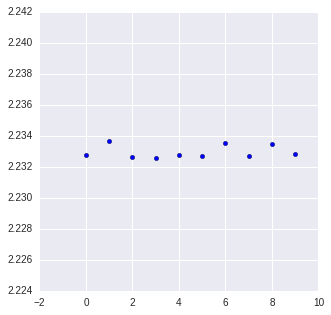

Epoch 11 of 500 took 0.263s
  training loss:		2.232698
  validation loss:		0.967140
  validation accuracy:		96.71 %


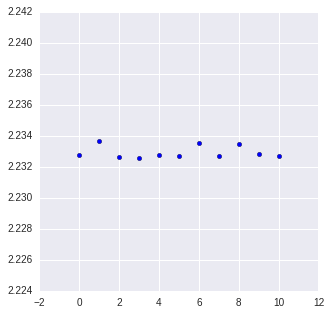

Epoch 12 of 500 took 0.263s
  training loss:		2.232097
  validation loss:		0.967155
  validation accuracy:		96.72 %


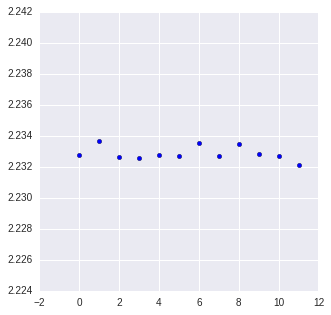

Epoch 13 of 500 took 0.273s
  training loss:		2.232273
  validation loss:		0.967130
  validation accuracy:		96.71 %


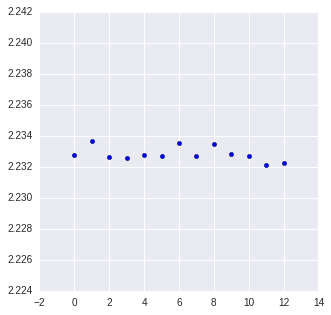

Epoch 14 of 500 took 0.263s
  training loss:		2.232783
  validation loss:		0.967140
  validation accuracy:		96.71 %


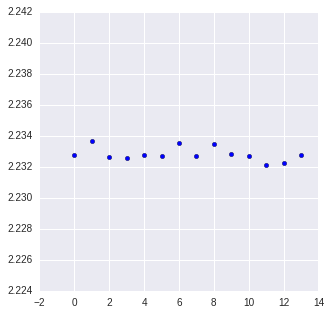

Epoch 15 of 500 took 0.260s
  training loss:		2.232071
  validation loss:		0.967150
  validation accuracy:		96.72 %


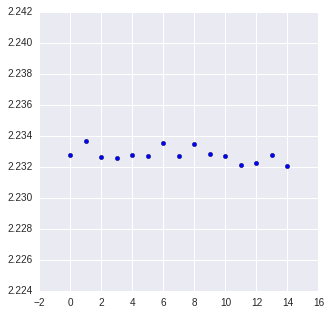

Epoch 16 of 500 took 0.284s
  training loss:		2.232137
  validation loss:		0.967130
  validation accuracy:		96.71 %


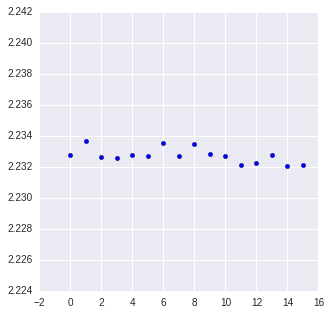

Epoch 17 of 500 took 0.282s
  training loss:		2.232647
  validation loss:		0.967130
  validation accuracy:		96.71 %


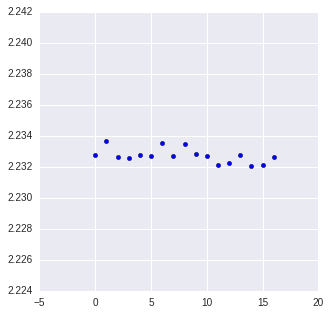

Epoch 18 of 500 took 0.265s
  training loss:		2.232491
  validation loss:		0.967160
  validation accuracy:		96.72 %


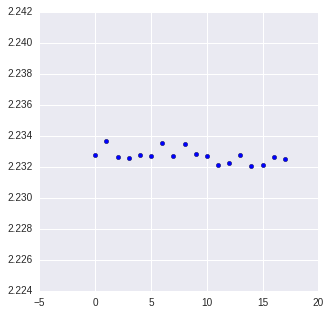

Epoch 19 of 500 took 0.286s
  training loss:		2.231334
  validation loss:		0.967135
  validation accuracy:		96.71 %


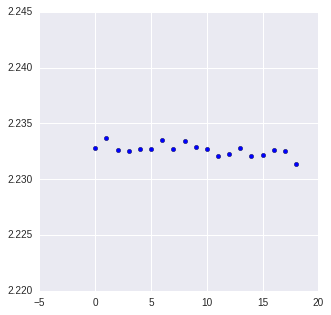

Epoch 20 of 500 took 0.263s
  training loss:		2.233288
  validation loss:		0.967155
  validation accuracy:		96.72 %


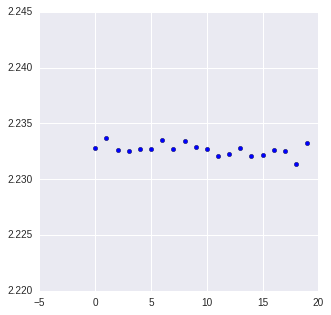

Epoch 21 of 500 took 0.282s
  training loss:		2.232465
  validation loss:		0.967125
  validation accuracy:		96.71 %


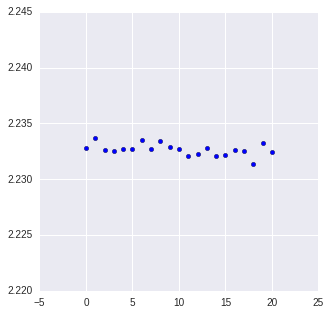

Epoch 22 of 500 took 0.277s
  training loss:		2.232198
  validation loss:		0.967155
  validation accuracy:		96.72 %


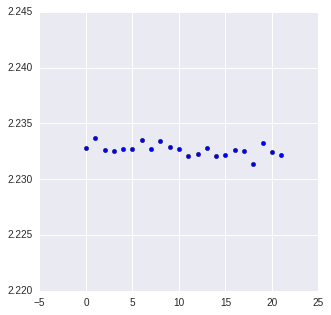

Epoch 23 of 500 took 0.266s
  training loss:		2.231930
  validation loss:		0.967175
  validation accuracy:		96.72 %


KeyboardInterrupt: 

In [40]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne
from lasagne.regularization import regularize_layer_params_weighted




def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, X_train.shape[2], 1),
                                        input_var=input_var)
    
    #####make a single dense layer
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=80,
            nonlinearity=lasagne.nonlinearities.rectify)
    
    
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)

    return network
    
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 1),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 1))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 1),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 1))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
#     network = lasagne.layers.DenseLayer(
#             lasagne.layers.dropout(network, p=.5),
#             num_units=256,
#             nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            network,
            #lasagne.layers.dropout(network, p=.5),
            num_units=1,
            nonlinearity=lasagne.nonlinearities.rectify)

    return network


def main(model='mlp', num_epochs=500):
    training_losses = []
    print(y_train)
    print(y_train.shape)
    print("train max", np.max(y_train))
    print("x train shape", X_train.shape)

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")

    network = build_cnn(input_var)


    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    reg = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2)
    reg_param = .01

    loss = lasagne.objectives.squared_error(prediction.transpose(), target_var)
    loss = loss.mean() + reg_param * reg
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.00001, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network)

    test_loss = lasagne.objectives.squared_error(test_prediction.transpose(),
                                                            target_var) 
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

    # Finally, launch the training loop.
    batch_size = 1000
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            #print(prediction(inputs))
#             print(inputs.shape)
#             print(targets)

            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=True):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        training_losses.append(train_err / train_batches)
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        plt.scatter(range(len(training_losses)), training_losses)
        plt.show()

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=True):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))
    
    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)


main()


### housing density - correlation with damage?  Apparently not.

In [ ]:
density = fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': -META ['pointx'],
                                             'y': META ['pointy']}), np.ones(len(META)), normalize_buckets = False)

y_shuffle = np.copy(np.array(Y_DATA['y200_mean']))
np.random.shuffle(y_shuffle)
damage = fast_show_ratio_plot(pandas.DataFrame.from_dict({'x': -META ['pointx'],
                                             'y': META ['pointy']}), np.array(Y_DATA['y200_mean']))
damage = damage[density != 0]

density = density[density != 0]
print density.flatten()
damage.flatten()
print pearsonr(density.flatten(), damage.flatten())